In [25]:
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# Trabajo Práctico 1 - Ejercicio 7 a 10

## Ejercicio 7

Se propone simular la evolución de una epidemia utilizando un modelo basado en agentes, en el cual el desplazamiento se modela como random walking.

Se considera una población de N individuos (utilizar distintos valor de N) distribuidos uniformemente sobre un área de 100 m x 100 m

(Representar esta área como una grilla de celdas de 0,5 x 0,5 m)
Se considera que inicialmente el 2% de los individuos tiene la enfermedad, y existen 3 tipos e individuos:

| Tipo        | Porcentaje  | Caracteristicas
| ----------- | ----------- | -----------
| A.          | 70%         | Se desplaza una celda por instantes de tiempo
| B.          | 25%         | Se desplaza una celda por cada dos instantes de tiempo
| C.          | 5%          | Se desplaza una celda por cada cuatro instantes de tiempo

Esta enfermedad puede ser transmitida con una la siguiente probabilidad:


| Prob        | Distancia entre sano y enfermo 
| ----------- | ----------- 
| 0.5         | 3 < celdas <= 6        
| 0.7         | 3 celdas o menos       


Suponer que las personas contagiadas no se pueden curar.
Realice una simulación hasta 5000 instantes de tiempo, o hasta que la población completa se contagie.

* Una animación de la situación planteada
* Obtenga estadísticas de los tiempos que demoran los individuos en contagiarse. Grafique.
* Graficar la curva de evolución de la epidemia midiendo.
   *  Cantidad de personas sanas en función del tiempo
   * Cantidad de personas enfermas en función del tiempo

In [6]:
# Esto es necesario para el ejercicio 9 en adelante
class EstadoSalud(object):
    def __init__(self):
        self.infectado = False
        
    def actualizar_estado(self):
        pass
    
    def infectar(self):
        pass
    
    def puede_infectarse(self):
        pass
    

class EstadoSaludIrrecuperable(EstadoSalud):
    def __init__(self):
        super().__init__()
        self.infectado = False
    
    def infectar(self):
        self.infectado = True
        
    def puede_infectarse(self):
        return not self.infectado
            
    def actualizar_estado(self):
        pass
        

class EstadoSaludRecuperable(EstadoSalud):
    def __init__(self, alpha, beta, reincidencia):
        super().__init__()
        self.infectado = False
        self.estuvo_infectado = False
        self.reincidencia = reincidencia
        self.tiempo_recuperacion = alpha
        self.prob_recuperacion = beta
        self.tiempo_hasta_recuperacion = 0
        
    def infectar(self):
        if self.puede_infectarse():
            self.infectado = True
            self.estuvo_infectado = True
            self.tiempo_hasta_recuperacion = self.tiempo_recuperacion
        
    def actualizar_estado(self):
        if self.tiempo_hasta_recuperacion == 0:
            p = random.uniform(0,1)
            if p < self.prob_recuperacion:
                self.infectado = False
        else:
            self.tiempo_hasta_recuperacion -= 1

    def puede_infectarse(self):
        return self.reincidencia or not self.estuvo_infectado


En un primer lugar se consideró implementar una clase para representar al individuo que será parte de la simulación. Para eso será necesario para este ejercicio un contador para representar cada cuánto se mueve cada tipo de individuo y la posición actual en coordenadas x e y. Otros atributos que se vean en esta clase son para los ejercicios que siguen y su uso será explicado posteriormente.

Se tomó como presupuesto que los únicos movimientos posibles de un individuo son a su izquierda, su derecha, hacia arriba o hacia abajo, impidiendo de esta forma los movimientos que sigan una línea diagonal. Como el movimiento de un individuo se modela con random walking la probabilidad de que se mueva hacia cada una de estas direcciones es la misma. 

In [7]:
TAMANIO_MATRIZ = 200 # Como las celdas son de 0.5mx0.5m y la grilla es de 100mx100m son 200 celdas
MOVIMIENTOS_POSIBLES = [(0,-1), (0,1), (1,0), (-1,0)]

class Individuo: 
    def __init__(self, reset_contador, x, y, estado_salud, p_misma_direccion = 0): 
        self.reset_contador = reset_contador
        self.contador = reset_contador
        self.x = x
        self.y = y
        self.mov = None
        self.p_misma_direccion = p_misma_direccion
        self.estado_salud = estado_salud
        
    def obtener_posicion(self):
        return self.x,self.y
    
    def infectar(self):
        self.estado_salud.infectar()
        
    def mover(self):
        self.contador -= 1
        if self.contador == 0:
            p = random.uniform(0,1)
            movimientos_posibles = MOVIMIENTOS_POSIBLES[:]
            if self.p_misma_direccion != 0 and self.mov:
                movimientos_posibles.remove(self.mov)
            if p < self.p_misma_direccion and self.mov:
                mov_x, mov_y = self.mov[0], self.mov[1]   
            else:           
                mov_x, mov_y = random.choice(movimientos_posibles)
            self.mov = (mov_x, mov_y)
            self.x = (self.x + mov_x) % TAMANIO_MATRIZ
            self.y = (self.y + mov_y) % TAMANIO_MATRIZ
            self.contador = self.reset_contador
    
    def obtener_estado_salud(self):
        return self.estado_salud
    
    def esta_infectado(self):
        return self.estado_salud.infectado

Luego se decidió modelar a la población para que se encargue de administrar los individuos, ubicarlos en el área simulada y controlar sus movimientos. Esta clase determina si el individuo se contagia cuando se encuentra en las cercanías de un infectado de acuerdo a las probabilidades establecidas por el enunciado.

In [8]:
RADIO_INFERIOR_PELIGROSO = 0
RADIO_SUPERIOR_PELIGROSO = 3
RADIO_SUPERIOR_CUIDADANIA = 6

class Poblacion:
    def __init__(self, individuos, p_peligroso, p_cuidadania, p_move=1):
        self.individuos = individuos
        self.mapa = [[[] for _ in range(TAMANIO_MATRIZ)] for _ in range(TAMANIO_MATRIZ)]
        self.infectados = set()
        self.p_peligroso = p_peligroso
        self.p_cuidadania = p_cuidadania
        self.p_move = p_move
        for individuo in self.individuos:
            x, y = individuo.obtener_posicion()
            self.mapa[x][y].append(individuo)
            if individuo.esta_infectado():
                self.infectados.add(individuo)
        
    def mover_individuos(self):
        nuevas_posiciones = []
        individuos_esenciales = self.individuos[:int(self.p_move*len(self.individuos))]
        for individuo in self.individuos:
            x_0, y_0 = individuo.obtener_posicion()
            if individuo in individuos_esenciales:
                individuo.mover()
            x, y = individuo.obtener_posicion()
            self.mapa[x_0][y_0].remove(individuo)
            self.mapa[x][y].append(individuo)
            nuevas_posiciones.append((x, y))
        return nuevas_posiciones
    
    def calcular_infectados(self):
        for individuo in self.individuos:
            individuo.obtener_estado_salud().actualizar_estado()
            
            if not individuo.esta_infectado() and individuo in self.infectados:
                self.infectados.remove(individuo)
                
            if not individuo.obtener_estado_salud().puede_infectarse():
                continue
        
            x, y = individuo.obtener_posicion()
            posiciones_covid_peligroso = self.obtener_posiciones(x, y, RADIO_INFERIOR_PELIGROSO, RADIO_SUPERIOR_PELIGROSO)
            for i, j in posiciones_covid_peligroso:
                individuos_a_comparar = self.mapa[i][j]
                for individuo_a_comparar in individuos_a_comparar:
                    if individuo_a_comparar.esta_infectado():
                        p = random.uniform(0,1)
                        if p < self.p_peligroso:
                            individuo.infectar()
                            self.infectados.add(individuo)
                            continue
            
            posiciones_covid_cuidadania = self.obtener_posiciones(x, y, RADIO_SUPERIOR_PELIGROSO, RADIO_SUPERIOR_CUIDADANIA)
            for i, j in posiciones_covid_cuidadania:
                individuos_a_comparar = self.mapa[i][j]
                for individuo_a_comparar in individuos_a_comparar:
                    if individuo_a_comparar.esta_infectado():
                        p = random.uniform(0,1)
                        if p < self.p_cuidadania:
                            individuo.infectar()
                            self.infectados.add(individuo)
                            continue
                    
    def obtener_posiciones(self, x, y, lim_inf, lim_sup):
        posiciones = []
        for i in range(lim_inf, lim_sup+1):
            for j in range(lim_inf, lim_sup+1):
                if i + j <= lim_sup and i + j > lim_inf:
                    posiciones.append(((x+i)%TAMANIO_MATRIZ, (y+j)% TAMANIO_MATRIZ))
                    posiciones.append(((x-i)%TAMANIO_MATRIZ, (y+j)% TAMANIO_MATRIZ))
                    posiciones.append(((x+i)%TAMANIO_MATRIZ, (y-j)% TAMANIO_MATRIZ))
                    posiciones.append(((x-i)%TAMANIO_MATRIZ, (y-j)% TAMANIO_MATRIZ))
        posiciones = list(dict.fromkeys(posiciones))
        return posiciones
        
    
    def imprimir_mapa(self):
        for x in range(TAMANIO_MATRIZ):
            for y in range(TAMANIO_MATRIZ):
                print(f"({x}, {y}): {len(self.mapa[x][y])}")
                
    def obtener_infectados(self):
        return len(self.infectados)

La función `crear_contexto` se utiliza para inicializar los individuos y determinar si están contagiados (el 2%) y almacenarlos en la población. Así mismo, se encarga de establecer el tipo de cada individuo de acuerdo al porcentaje del enunciado y de determinar su posición con una distribución uniforme.

In [9]:
TIPO_A = 1
PORCENTAJE_A = 0.7
TIPO_B = 2
PORCENTAJE_B = 0.25
TIPO_C = 4
PORCENTAJE_C = 0.05
PORCENTAJE_INFECTADOS = 0.02

def crear_contexto(n_personas, p_peligroso, p_cuidadania, p=0, estado_salud_factory=None, p_move=1):
    personas = []
    for i in range(n_personas):
        rand_x = int(random.uniform(0,TAMANIO_MATRIZ))
        rand_y = int(random.uniform(0,TAMANIO_MATRIZ))
        
        reset_counter = None
        
        tope_reset_counter_inf = int(n_personas*PORCENTAJE_A)
        tope_reset_counter_sup = int(n_personas*(PORCENTAJE_A + PORCENTAJE_B))
        
        if i <= tope_reset_counter_inf:
            reset_counter = TIPO_A
        elif tope_reset_counter_inf <= i <= tope_reset_counter_sup:
            reset_counter = TIPO_B
        else:
            reset_counter = TIPO_C
            
        estado_salud = EstadoSaludIrrecuperable()
        
        if estado_salud_factory:
            estado_salud = estado_salud_factory()

        individuo = Individuo(reset_counter, rand_x, rand_y, estado_salud, p)
        personas.append(individuo)

    random.shuffle(personas)
    for i in range(int(n_personas*PORCENTAJE_INFECTADOS)):
        personas[i].infectar()
    poblacion = Poblacion(personas, p_peligroso, p_cuidadania, p_move=p_move)
    return personas, poblacion

La función `animar_situacion`, como su nombre lo indica, se encarga de realizar la animación de la situación para poder tener una representación gráfica de los contagios a medida que transcurren los instantes de tiempo. Los individuos infectados se representan con el color rojo y los que no lo están con color azul.

In [36]:
def animar_situacion(personas, poblacion, interval, frames):
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(xlim=(-1,TAMANIO_MATRIZ+1),ylim=(-1,TAMANIO_MATRIZ+1))

    posiciones_x = []
    posiciones_y = []
    colores = []
    for p in personas:
        posiciones_x.append(p.obtener_posicion()[0])
        posiciones_y.append(p.obtener_posicion()[1])
        if p.esta_infectado():
            colores.append('red')
        else:
            colores.append('blue')

    scatter = ax.scatter(posiciones_x, posiciones_y, color=colores)

    def update(frame_number):
        posiciones = poblacion.mover_individuos()
        colores = []
        poblacion.calcular_infectados()
        for p in personas:
            if p.esta_infectado():
                colores.append('red')
            else:
                colores.append('blue')
        scatter.set_offsets(posiciones)
        scatter.set_color(colores)
        return scatter,

    return FuncAnimation(fig, update, interval=interval, frames=frames)

La función `contagiar_todos` se encarga de calcular cuántos instantes de tiempo lleva contagiar a toda la población con un tope de 5000 instantes de tiempo para asegurar que la función tiene un corte. Así mismo, por cada instante de tiempo se calcula la cantidad de infectados, información que será útil para los gráficos de análisis que se observarán luego.

In [12]:
def contagiar_todos(poblacion, personas):
    instantes_de_tiempo = 0
    infectados_por_instante = []
    infectados = poblacion.obtener_infectados()
    infectados_por_instante.append(infectados)
    while infectados < len(personas) and instantes_de_tiempo <= 5000:
        poblacion.mover_individuos()
        poblacion.calcular_infectados()
        instantes_de_tiempo += 1
        infectados = poblacion.obtener_infectados()
        infectados_por_instante.append(infectados) 
    return instantes_de_tiempo, infectados_por_instante

La función `obtener_estadisticas_muestra` se utiliza para correr una misma simulación varias veces con el fin de observar cómo vaŕian las simulaciones.

In [13]:
def obtener_estadisticas_muestra(muestra, p_peligroso, p_cuidadania): 
    resultado = []

    for i in range(muestra):
        personas, poblacion = crear_contexto(CANTIDAD_PERSONAS, p_peligroso, p_cuidadania)
        resultado.append(contagiar_todos(poblacion, personas)[0])
        
    return resultado

La función `graficar_instantes_contagio` se utiliza para graficar la cantidad de instantes de tiempo que lleva contagiar a toda la población.

In [14]:
def graficar_instantes_contagio(resultado):
    plt.title('Instantes de tiempo para contagiar toda la poblacion')
    plt.hist(resultado, bins=60, alpha=1, edgecolor = 'black',  linewidth=1)
    plt.grid(True)
    plt.show()
    plt.clf()

La función `obtener_resultados_multiples_N` se encarga de calcular cuánto tiempo lleva contagiar a toda la población con diversas cantidades de poblaciones. La idea es que sea útil para el análisis de la correlación entre la cantidad de gente y la velocidad de transmisión de la enfermedad en el contexto de la epidemia simulada.

In [15]:
def obtener_resultados_multiples_N(cantidades, p_peligroso, p_cuidadania, p=0, p_move=1):
    resultado = []
    for cantidad in cantidades:
        personas, poblacion = crear_contexto(cantidad, p_peligroso, p_cuidadania, p=p, p_move=p_move)
        resultado.append(contagiar_todos(poblacion, personas)[0])
    return resultado

La función `graficar_instantes_contagio_por_cantidades` se encarga de graficar la cantidad de instantes de tiempo que lleva contagiar a toda la población de acuerdo a la cantidad de habitantes de la población.

In [17]:
def graficar_instantes_contagio_por_cantidades(resultado, cantidades):
    plt.title('Instantes de tiempo para contagiar toda la poblacion por cantidad de poblacion')
    plt.bar([i for i in range(1, len(cantidades)+1)], resultado, color="green", alpha=1, edgecolor = 'black',  linewidth=1)
    plt.xticks([i for i in range(1, len(cantidades)+1)], cantidades)
    plt.grid(True)
    plt.show()
    plt.clf()

La función `crear_contexto_por_cantidad` se encarga de crear el contexto de acuerdo a una cantidad de personas específica pasada por parámetro y así devolver el tiempo que lleva contagiar a toda la población junto con la cantidad de infectados por cada instante de tiempo.

In [19]:
def crear_contexto_por_cantidad(cantidad_personas, p_peligroso, p_cuidadania, p=0, estado_salud_factory=None, p_move=1):
    personas, poblacion = crear_contexto(cantidad_personas, p_peligroso, p_cuidadania, p=p, estado_salud_factory=estado_salud_factory, p_move=p_move)
    return contagiar_todos(poblacion, personas)

La función `obtener_diferencia_infectados_por_tiempo` se encarga de obtener cuántos infectados aumentaron o descendieron (en el contexto de otros ejercicios se podrán curar) por instante de tiempo

In [20]:
def obtener_diferencia_infectados_por_tiempo(diferencia_infectados_inicial, len_diferencia, infectados_por_tiempo): #infectados_por_tiempo[0], len(infectados_por_tiempo)
    diferencia_de_infectados = [diferencia_infectados_inicial]
    for i in range(1, len_diferencia):
        diferencia = infectados_por_tiempo[i] - infectados_por_tiempo[i-1]
        diferencia_de_infectados.append(diferencia)
    return diferencia_de_infectados

La función `graficar_nuevos_infectados_tiempo` se encarga de graficar los nuevos infectados en función del tiempo. Para ejercicios posteriores, si la cantidad representada es negativa esto implica que en ese instante de tiempo se curaron más personas que las que se infectaron.

In [21]:
def graficar_nuevos_infectados_tiempo(diferencia_de_infectados, instantes):
    points = np.arange(0, instantes+1)

    plt.figure(dpi=125, figsize=(6, 6))
    plt.plot(points, diferencia_de_infectados, color="orange")
    plt.title("Nuevos infectados en funcion del tiempo")
    plt.show()

La función `graficar_enfermos_tiempo` se encarga de graficar la cantidad de infectados en función del tiempo.

In [22]:
def graficar_enfermos_tiempo(infectados_por_tiempo, instantes):
    points = np.arange(0, instantes+1)

    plt.figure(dpi=125, figsize=(6, 6))
    plt.plot(points, infectados_por_tiempo, color="red")
    plt.title("Infectados en funcion del tiempo")
    plt.show()

La función `graficar_sanos_tiempo` se encarga de graficar la cantidad de personas que no están infectadas en función del tiempo.

In [23]:
def graficar_sanos_tiempo(infectados_por_tiempo, cantidad_personas, instantes):
    points = np.arange(0, instantes+1)

    plt.figure(dpi=125, figsize=(6, 6))
    plt.plot(points, [cantidad_personas - x for x in infectados_por_tiempo], color="limegreen")
    plt.title("Personas sanas en funcion del tiempo")
    plt.show()

Luego de la definición de todas las funciones que serán pertinentes en el análisis se procede a utilizarlas con los distintos parámetros que se considera que aporta valor para el mismo.

In [32]:
CANTIDAD_PERSONAS = 100
P_PELIGROSO = 0.7
P_CUIDADANIA = 0.5

personas, poblacion = crear_contexto(CANTIDAD_PERSONAS, P_PELIGROSO, P_CUIDADANIA)

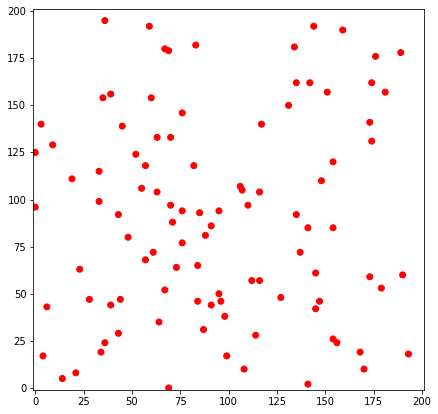

In [37]:
anim = animar_situacion(personas, poblacion, 10, 5000)
HTML(anim.to_html5_video())

Como se puede observar en la simulación, inicialmente se encuentran contagiados solo 2 individuos y al final de la simulación se encuentran contagiados todos los individuos. Esto es lógico ya que los individuos que se contagian no tienen cura en este escenario y además no dejan de moverse en ningún instante por lo que propagan la infección por toda el área de estudio.

**Nota al respecto**: si bien pareciera que hay más de 2 contagiados al inicio esto es porque cada instante de tiempo es de 10ms y no es apreciable al ojo humano. Esto fue hecho así para que el video no sea muy largo y se pueda observar la simulación de principio a fin fácilmente. Si se quiere observar en más detalle cómo es el inicio de la simulación debería bajarse la cantidad de frames y aumentar el interval para que sea apreciable la cantidad de individuos del inicio.

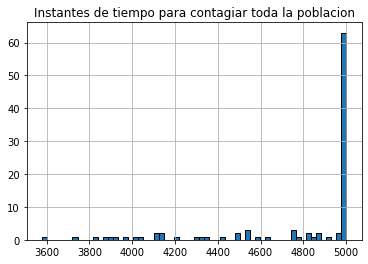

<Figure size 432x288 with 0 Axes>

In [38]:
MUESTRA = 100
resultado = obtener_estadisticas_muestra(MUESTRA, P_PELIGROSO, P_CUIDADANIA)
graficar_instantes_contagio(resultado)

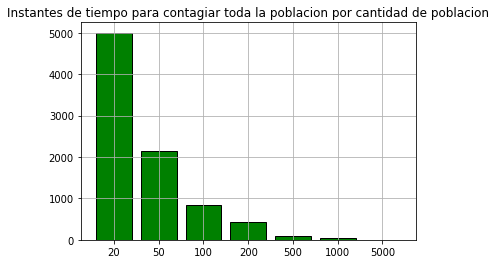

<Figure size 432x288 with 0 Axes>

In [354]:
CANTIDADES_A_EVALUAR = [20, 50, 100, 200, 500, 1000, 5000]
resultado = obtener_resultados_multiples_N(CANTIDADES_A_EVALUAR, 0.7, 0.5)
graficar_instantes_contagio_por_cantidades(resultado, CANTIDADES_A_EVALUAR)

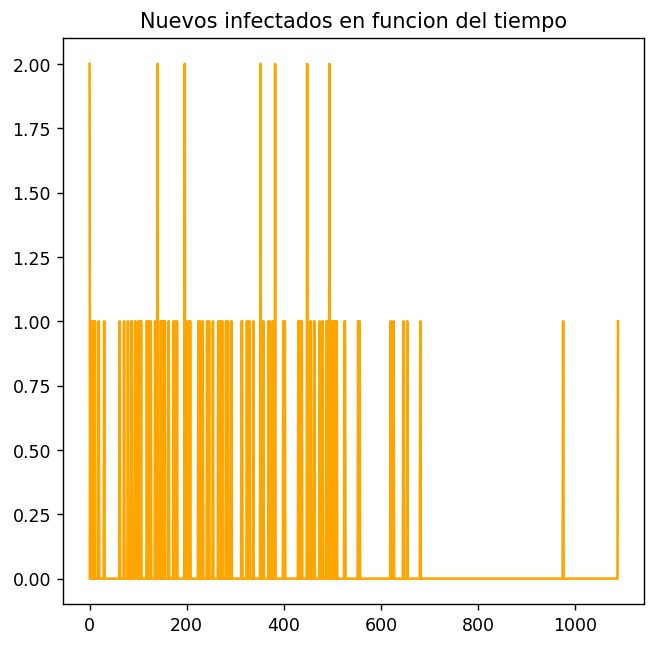

In [355]:
instantes, infectados_por_tiempo = crear_contexto_por_cantidad(CANTIDAD_PERSONAS, 0.7, 0.5)
diferencia_de_infectados = obtener_diferencia_infectados_por_tiempo(infectados_por_tiempo[0], len(infectados_por_tiempo), infectados_por_tiempo)
graficar_nuevos_infectados_tiempo(diferencia_de_infectados, instantes)

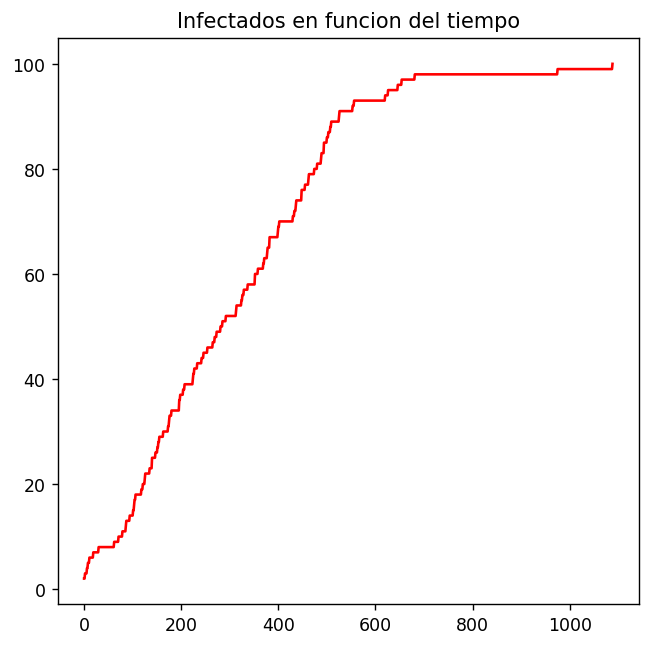

In [358]:
graficar_enfermos_tiempo(infectados_por_tiempo, instantes)

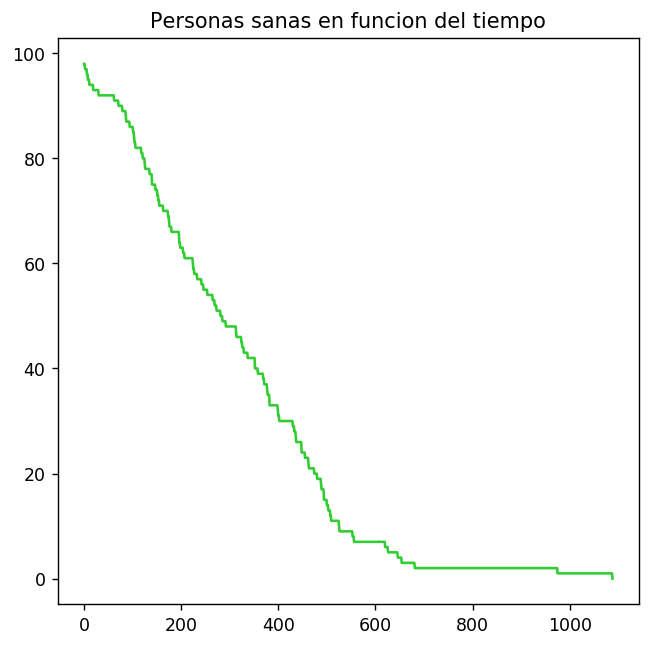

In [359]:
graficar_sanos_tiempo(infectados_por_tiempo, CANTIDAD_PERSONAS, instantes)

## Ejercicio 8

Repita el ejercicio 7 modelando el desplazamiento de la población como correlated random walking. En este modelo
suponer que, para cada individuo, la probabilidad de continuar desplazándose en la misma dirección que el paso de tiempo
anterior es 0,4, y equiprobable para las restantes direcciones.

Suponer que las personas contagiadas no se pueden curar.

Realice una simulación hasta 5000 instantes de tiempo, o hasta que la población completa se contagie.
Se pide:
- Una animación de la situación planteada
- Obtenga estadísticas de los tiempos que demoran los individuos en contagiarse. Grafique.
- Graficar la curva de evolución de la epidemia midiendo.
    * Cantidad de personas sanas en función del tiempo
    * Cantidad de personas enfermas en función del tiempo

In [360]:
CANTIDAD_PERSONAS = 100
personas, poblacion = crear_contexto(CANTIDAD_PERSONAS, 0.7, 0.5, p = 0.4)

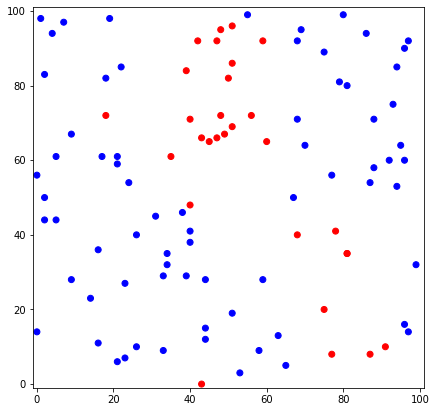

In [361]:
anim = animar_situacion(personas, poblacion, 100, 200)
HTML(anim.to_html5_video())

In [43]:
# TODO: se podrían agregar estadísticas por muestra como en el ejercicio 7

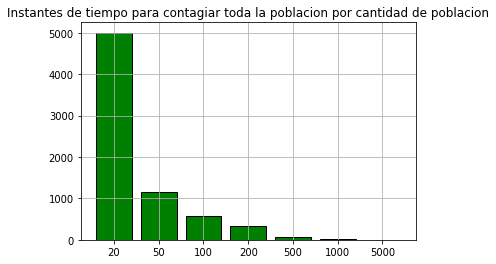

<Figure size 432x288 with 0 Axes>

In [362]:
cantidades_a_evaluar = [20, 50, 100, 200, 500, 1000, 5000]
resultado = obtener_resultados_multiples_N(cantidades_a_evaluar, 0.7, 0.5, p=0.4)
graficar_instantes_contagio_por_cantidades(resultado, cantidades_a_evaluar)

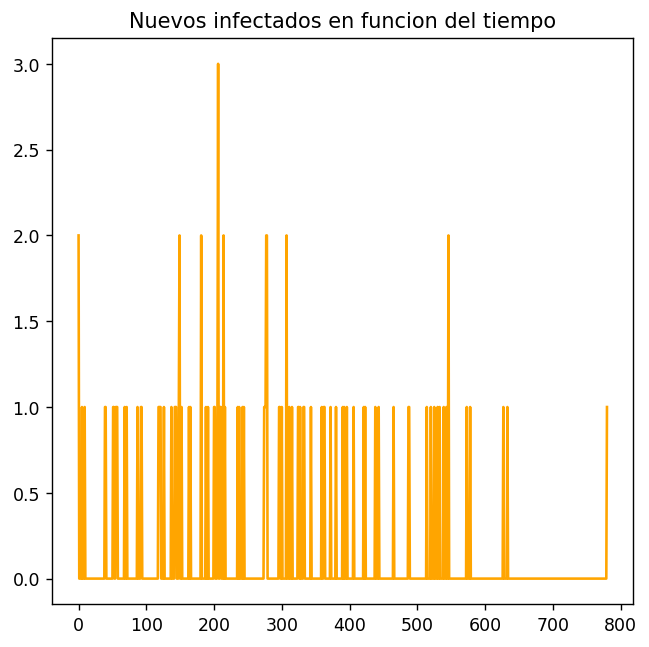

In [363]:
instantes, infectados_por_tiempo = crear_contexto_por_cantidad(CANTIDAD_PERSONAS, 0.7, 0.5, p = 0.4)
diferencia_de_infectados = obtener_diferencia_infectados_por_tiempo(infectados_por_tiempo[0], len(infectados_por_tiempo), infectados_por_tiempo)
graficar_nuevos_infectados_tiempo(diferencia_de_infectados, instantes)

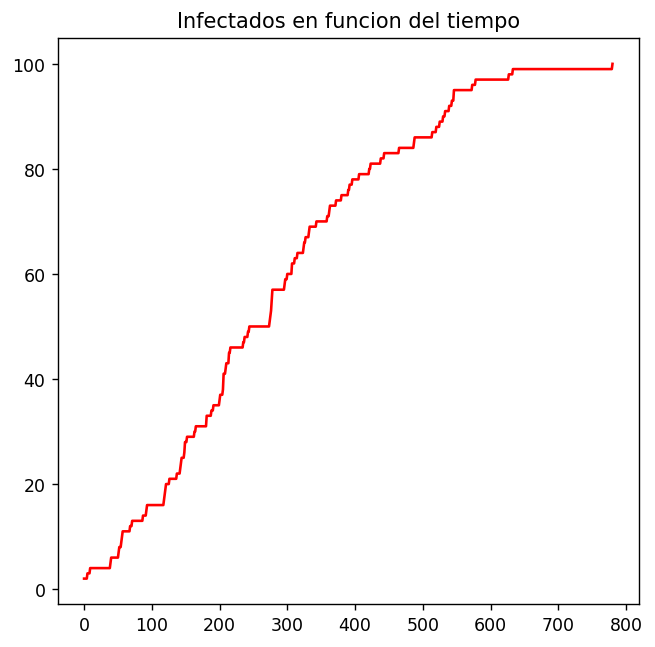

In [364]:
graficar_enfermos_tiempo(infectados_por_tiempo, instantes)

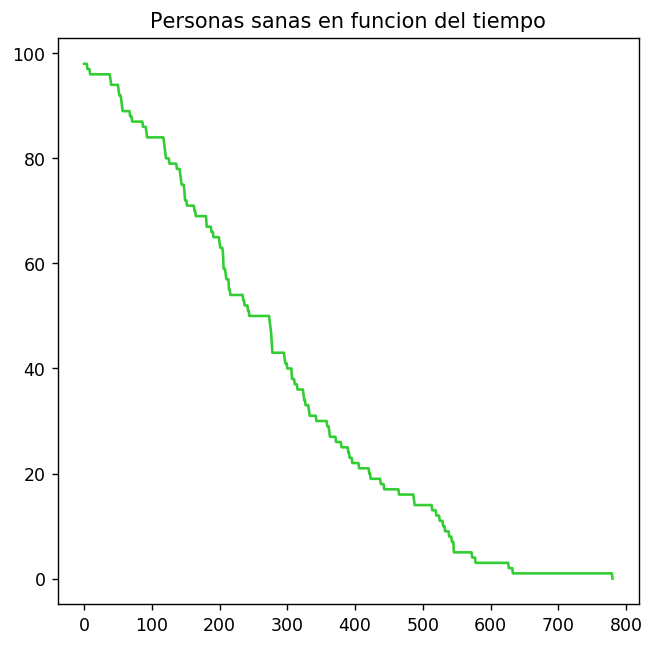

In [365]:
graficar_sanos_tiempo(infectados_por_tiempo, CANTIDAD_PERSONAS, instantes)

## Ejercicio 9

Para alguno de los modelos de desplazamiento implementado en los ejercicios 7 u 8, evalúe alternativas siguiendo los
siguientes criterios (también se pueden proponer alternativas por fuera del enunciado).
Las personas enfermas, luego de pasar α instantes de tiempo en ese estado, tienen una probabilidad de sanar del β% en
cada uno de los instantes de tiempo siguientes. Considerar escenarios en donde una persona curada puede volver a
contagiarse, y escenarios en donde una persona recuperada no puede contagiarse nuevamente.

Utilizando distintos valores de N, α, β y T, y las situaciones anteriores simular la evolución de la epidemia, a través de 5.000
instantes de tiempo.

Se pide:
- Una animación de la situación planteada
- Obtenga estadísticas de los tiempos que demoran los individuos en contagiarse. Grafique.
- Graficar la curva de evolución de la epidemia midiendo.
     * Cantidad de personas sanas en función del tiempo
     * Cantidad de personas enfermas en función del tiempo

In [366]:
def crear_estado_salud(alpha, beta, reincidencia):
    def estado_salud_factory():
        return EstadoSaludRecuperable(alpha, beta, reincidencia)
    return estado_salud_factory

In [367]:
CANTIDAD_PERSONAS = 100 
def graficar_analisis_situacional(alpha, beta, reincidencia):
    cantidades_a_evaluar = [20, 50, 100, 200, 500, 1000, 5000]
    resultado = obtener_resultados_multiples_N(cantidades_a_evaluar, 0.7, 0.5)
    graficar_instantes_contagio_por_cantidades(resultado, cantidades_a_evaluar)
    plt.clf()
    plt.cla()
    plt.close()
    
    instantes, infectados_por_tiempo = crear_contexto_por_cantidad(CANTIDAD_PERSONAS, 0.7, 0.5, p=0.4, estado_salud_factory=crear_estado_salud(alpha, beta, reincidencia))
    diferencia_de_infectados = obtener_diferencia_infectados_por_tiempo(infectados_por_tiempo[0], len(infectados_por_tiempo), infectados_por_tiempo)
    graficar_nuevos_infectados_tiempo(diferencia_de_infectados, instantes)
    plt.clf()
    plt.cla()
    plt.close()
    
    graficar_enfermos_tiempo(infectados_por_tiempo, instantes)
    graficar_sanos_tiempo(infectados_por_tiempo, CANTIDAD_PERSONAS, instantes)    

In [368]:
def animar_analisis_situacional(alpha, beta, reincidencia):
    personas, poblacion = crear_contexto(CANTIDAD_PERSONAS, 0.7, 0.5, p = 0.4, estado_salud_factory = crear_estado_salud(alpha, beta, reincidencia))
    anim = animar_situacion(personas, poblacion, 100, 200)
    return anim

## Primer escenario
Se recuperan a la mitad de la simulación obligatoriamente y no pueden reincidir.

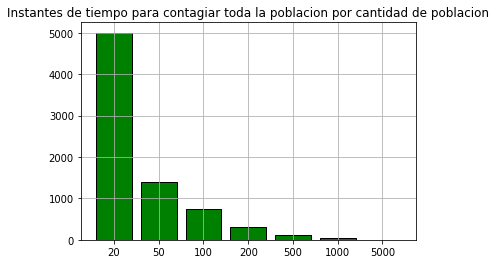

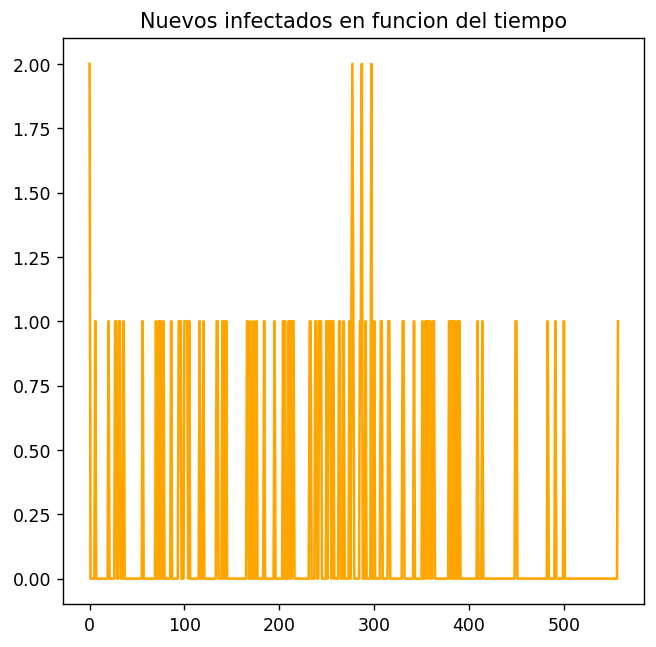

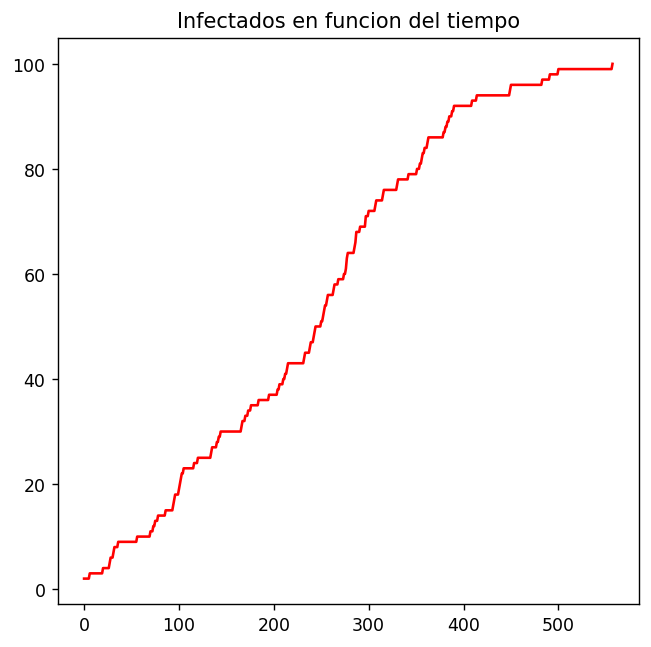

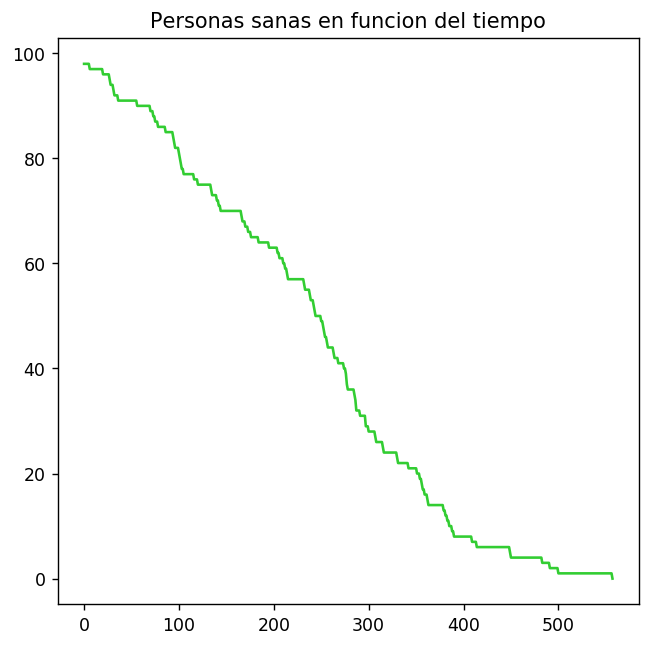

In [369]:
graficar_analisis_situacional(2500, 1, False)

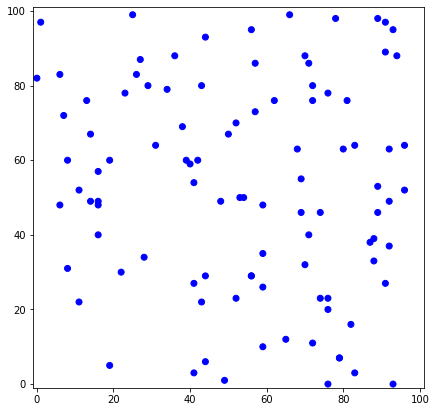

In [370]:
anim = animar_analisis_situacional(10, 1, False) #correr luego
HTML(anim.to_html5_video())

## Segundo escenario
Se recuperan a la mitad de la simulación obligatoriamente pero pueden reincidir.

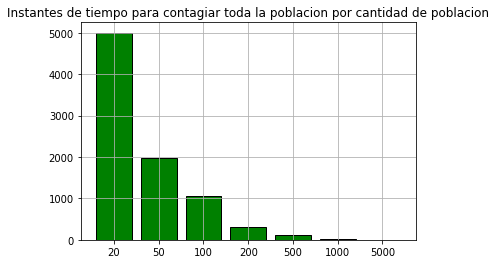

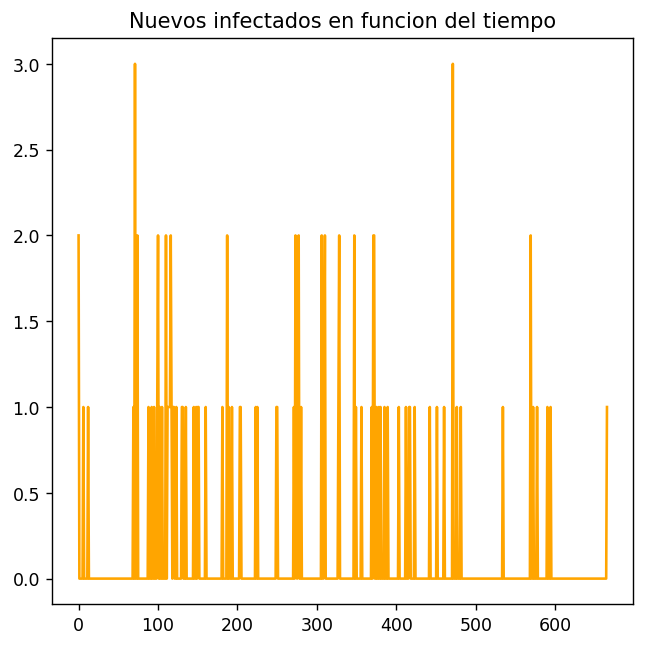

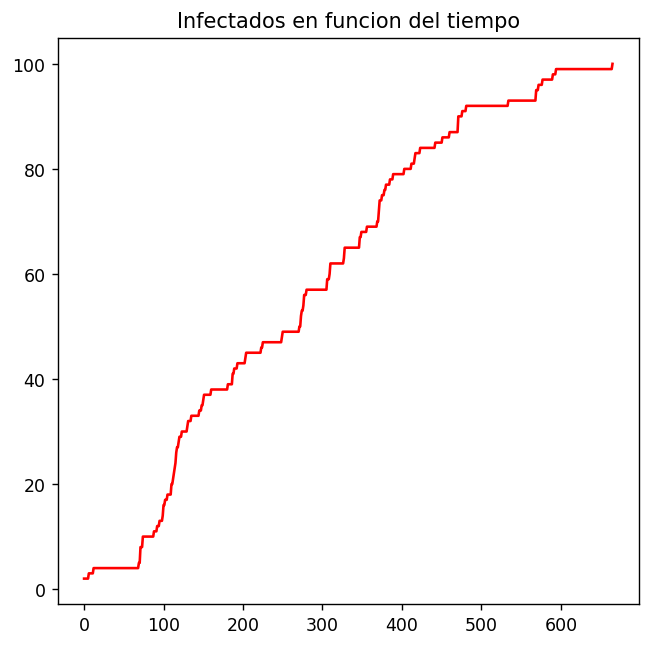

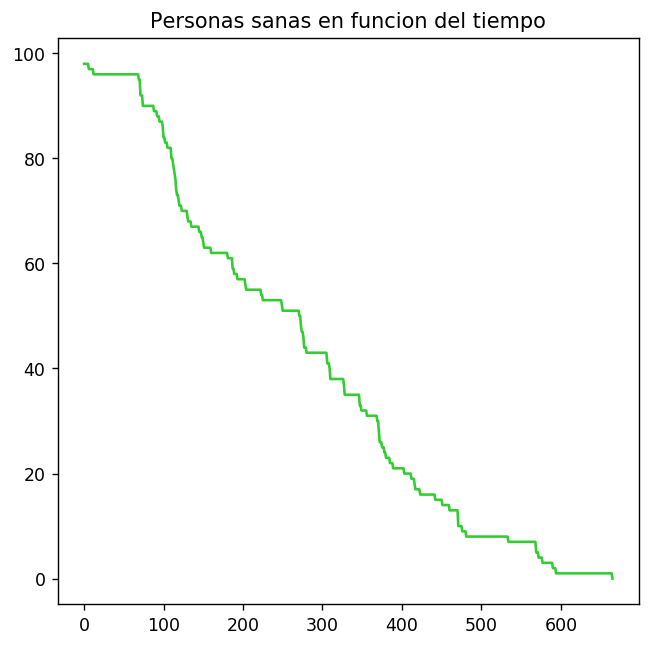

In [371]:
graficar_analisis_situacional(2500, 1, True)

In [324]:
# agregar animacion

## Tercer escenario
Se recuperan en los últimos instantes de la simulación obligatoriamente y no pueden reincidir.

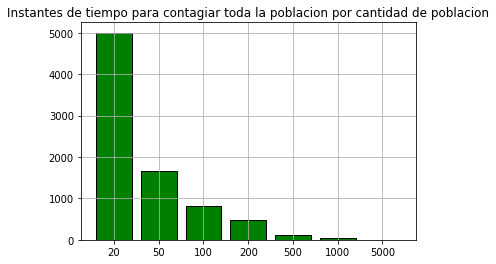

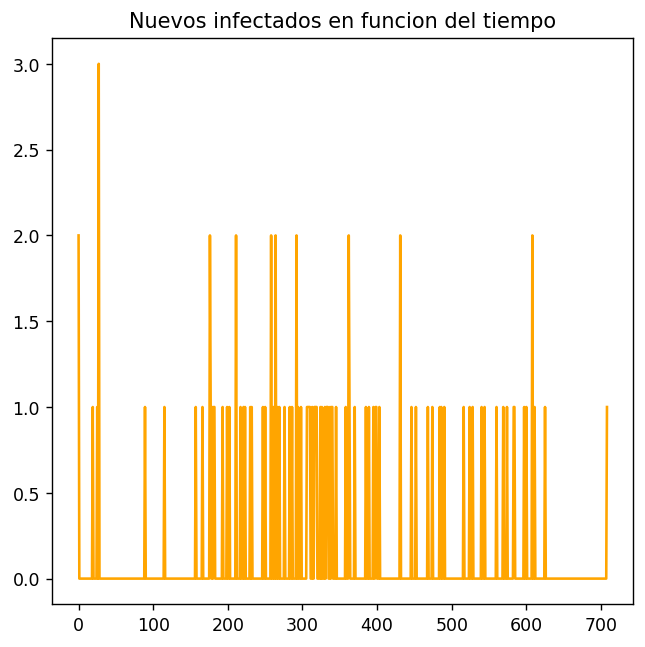

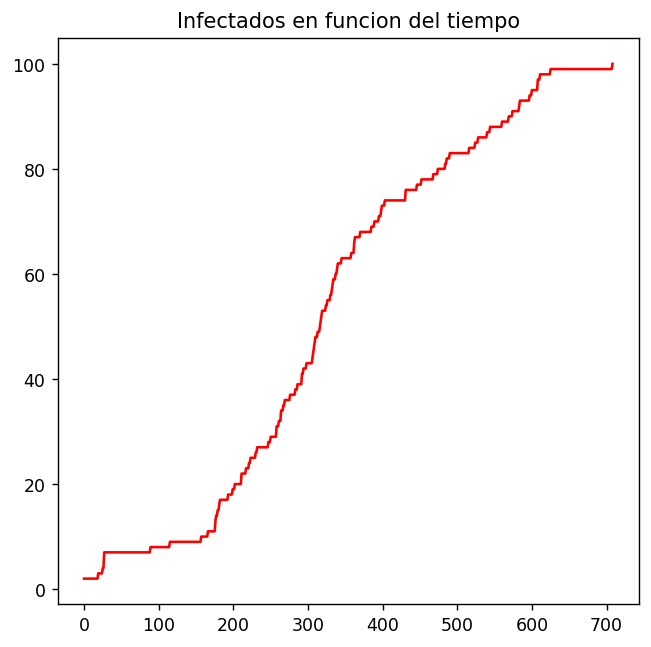

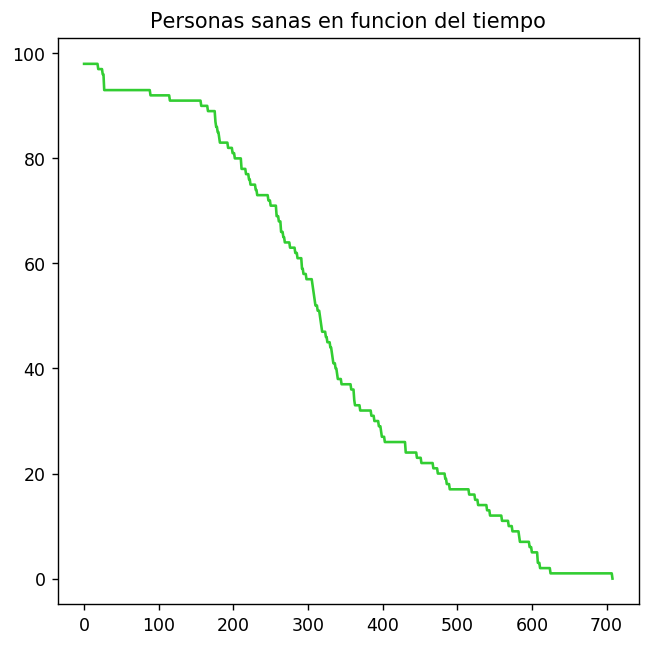

In [372]:
graficar_analisis_situacional(4900, 1, False)

In [329]:
# agregar animacion

## Cuarto escenario
Se recuperan en los últimos instantes de la simulación obligatoriamente y pueden reincidir.

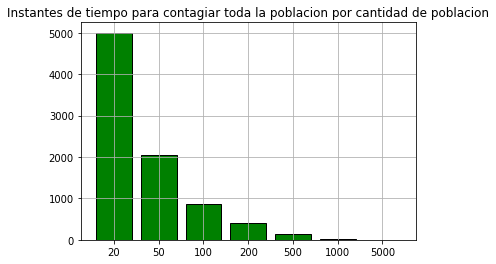

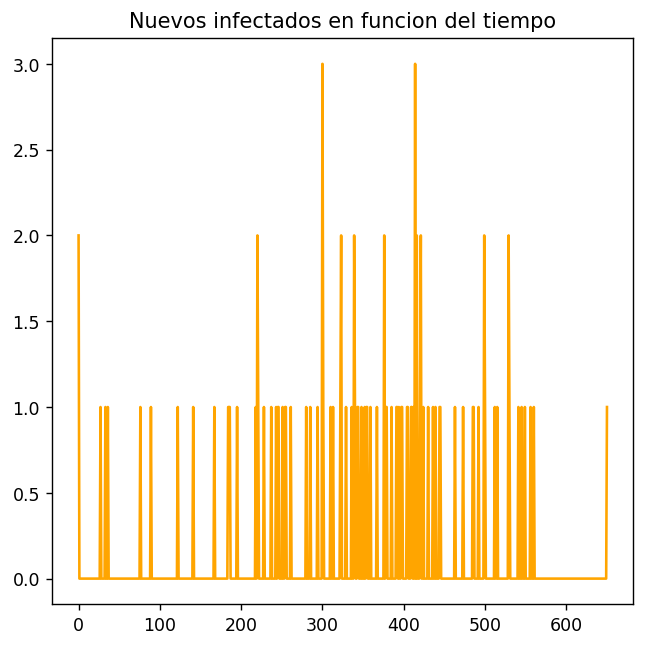

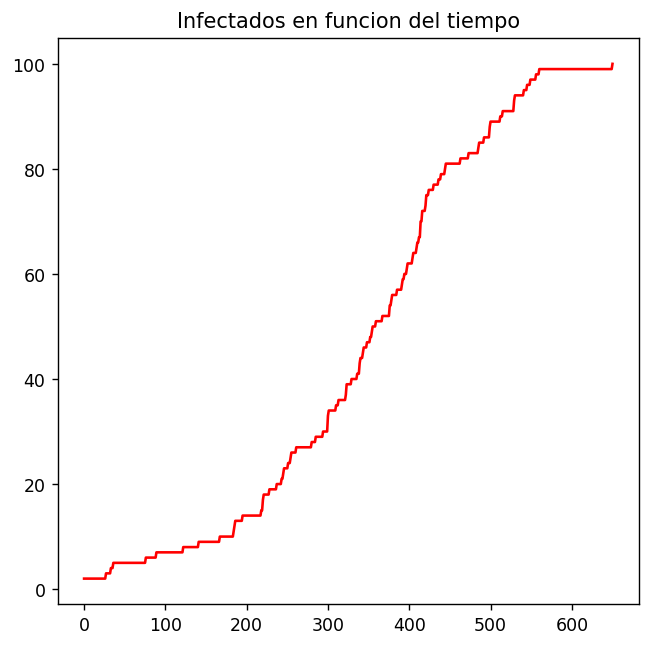

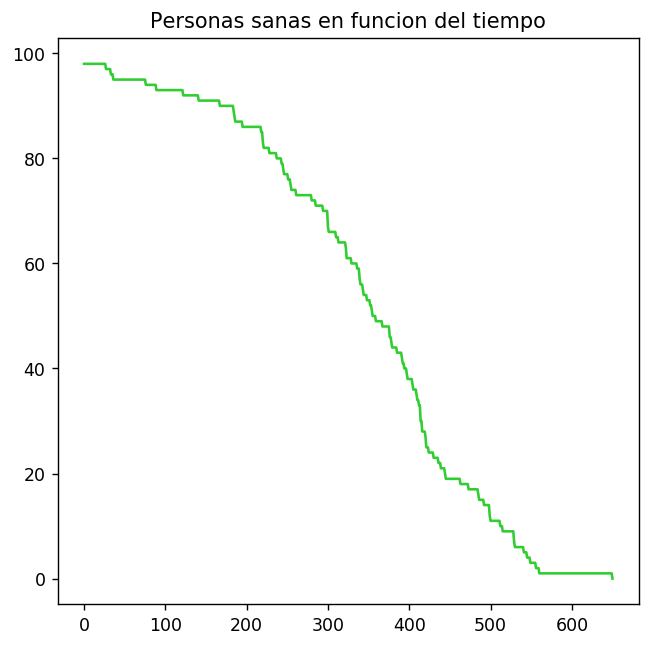

In [373]:
graficar_analisis_situacional(4900, 1, True)

In [330]:
# agregar animacion

## Quinto escenario
Se recuperan en el medio de la simulación con una probabilidad de 0.5 y pueden reincidir.

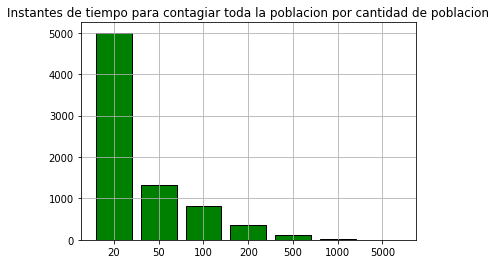

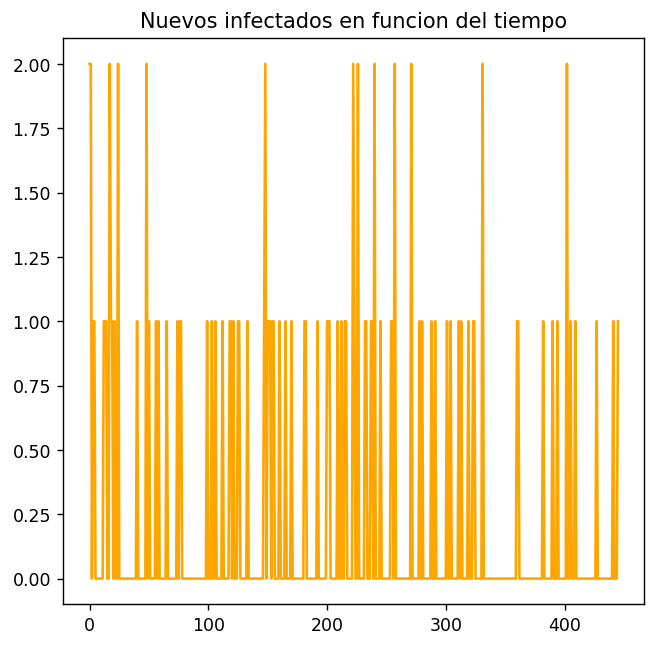

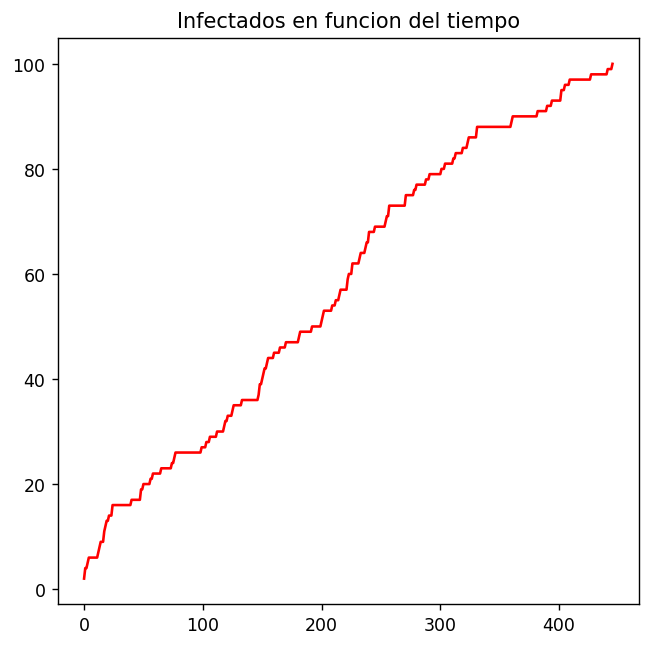

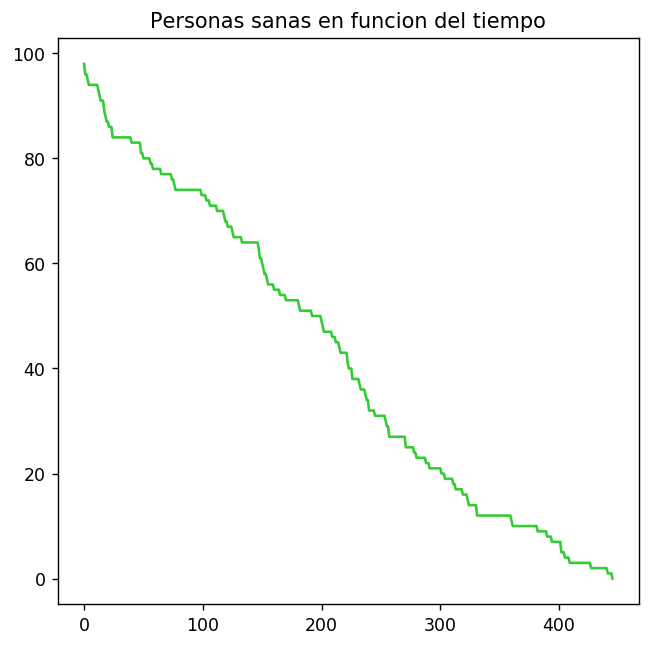

In [374]:
graficar_analisis_situacional(2500, 0.5, True)

In [332]:
# agregar animacion

## Sexto escenario
Se recuperan en el medio de la simulación con una probabilidad de 0.5 y no pueden reincidir.

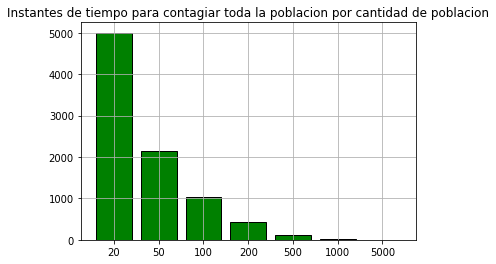

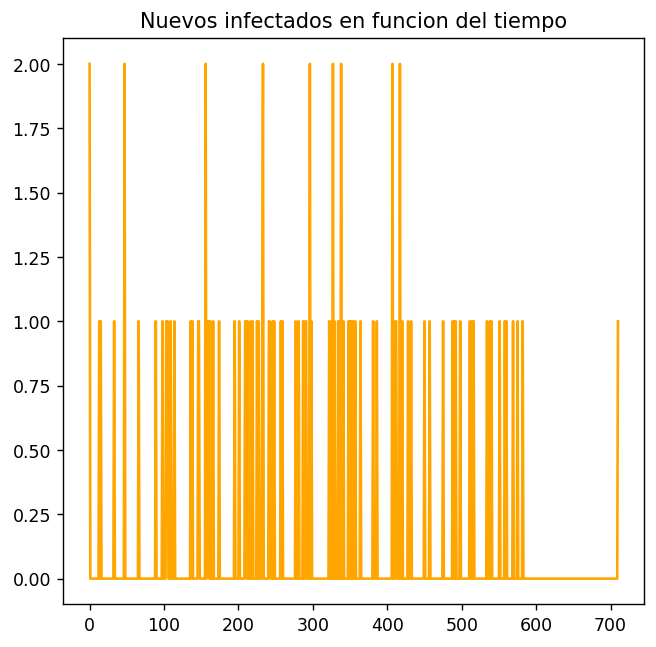

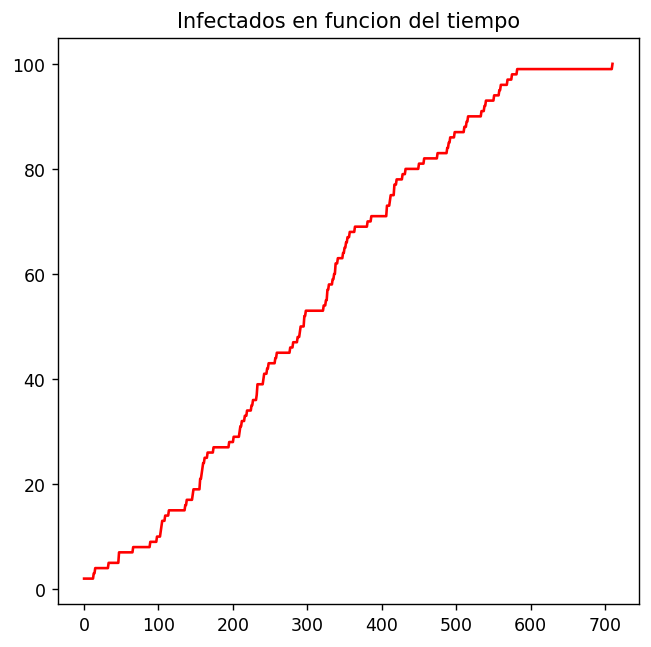

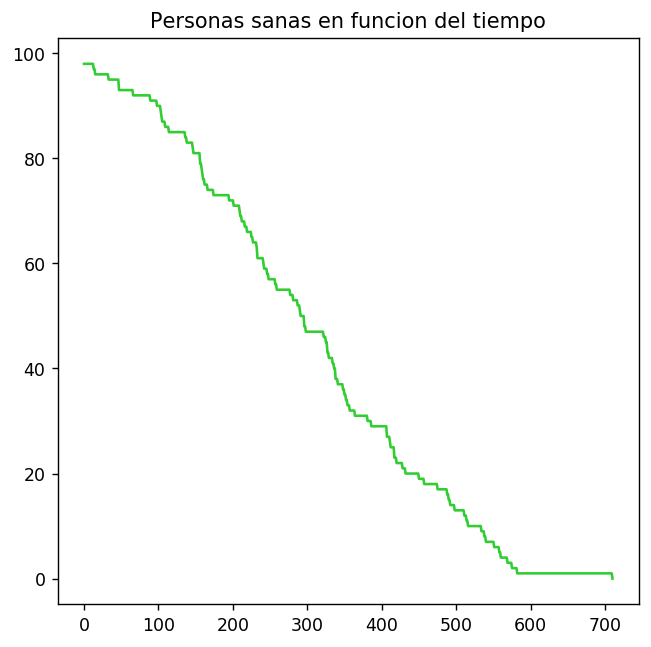

In [375]:
graficar_analisis_situacional(2500, 0.5, False)

In [335]:
# agregar animacion

## Ejercicio 10

Elegir alguna de las alternativas propuestas en el ejercicio 9, y suponer que el gobierno implementa medidas
por las cuales sólo se mueve el λ% de la población (probar con distintos valores de λ), el resto mantiene sus posiciones durante toda la simulación, y las probabilidades de contagio se modifican a:


| Prob        | Distancia entre sano y enfermo 
| ----------- | ----------- 
| 0.25         | 3 < celdas <= 6        
| 0.4         | 3 celdas o menos     

Se pide:
- Comparar con la situación elegida en el punto 9.
- Obtenga estadísticas de los tiempos que demoran los individuos en contagiarse. Grafique.
- Graficar la curva de evolución de la epidemia midiendo.
     * Cantidad de personas sanas en función del tiempo
     * Cantidad de personas enfermas en función del tiempo

Se considera como supuesto que siempre se mueve el mismo λ% de la población, es decir, que hay individuos de la población que se quedarán quietos durante toda la simulación.

Tomamos la situación en la que se recuperan con una probabilidad de 1 en el medio de la simulación y se pueden volver a contagiar.

In [385]:
alpha = 100 # change to 2500
beta = 1
reincidencia = True

In [399]:
CANTIDAD_PERSONAS = 100 
def graficar_analisis_situacional_con_cuarentena(p_move):
    cantidades_a_evaluar = [20, 50, 100, 200, 500, 1000, 5000]
    resultado = obtener_resultados_multiples_N(cantidades_a_evaluar, 0.4, 0.25, p_move=p_move)
    graficar_instantes_contagio_por_cantidades(resultado, cantidades_a_evaluar)
    plt.clf()
    plt.cla()
    plt.close()
    
    instantes, infectados_por_tiempo = crear_contexto_por_cantidad(CANTIDAD_PERSONAS, 0.4, 0.25, p=0.4, estado_salud_factory=crear_estado_salud(alpha, beta, reincidencia), p_move=p_move)
    diferencia_de_infectados = obtener_diferencia_infectados_por_tiempo(infectados_por_tiempo[0], len(infectados_por_tiempo), infectados_por_tiempo)
    graficar_nuevos_infectados_tiempo(diferencia_de_infectados, instantes)
    plt.clf()
    plt.cla()
    plt.close()
    
    graficar_enfermos_tiempo(infectados_por_tiempo, instantes)
    graficar_sanos_tiempo(infectados_por_tiempo, CANTIDAD_PERSONAS, instantes)   

In [400]:
def animar_analisis_situacional_con_cuarentena(p_move):
    personas, poblacion = crear_contexto(CANTIDAD_PERSONAS, 0.4, 0.25, p = 0.4, estado_salud_factory = crear_estado_salud(alpha, beta, reincidencia), p_move=p_move)
    anim = animar_situacion(personas, poblacion, 100, 200)
    return anim

## Situacion 1
Ningún individuo se puede mover así que los infectados no se mueven, se curan y los que lo rodean tiene una probabilidad alta de curarse.

1
2


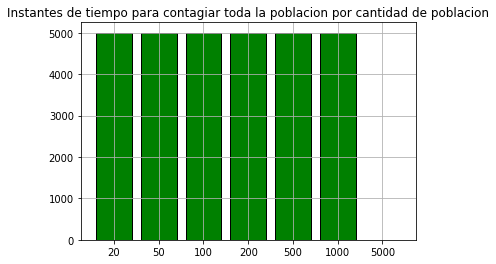

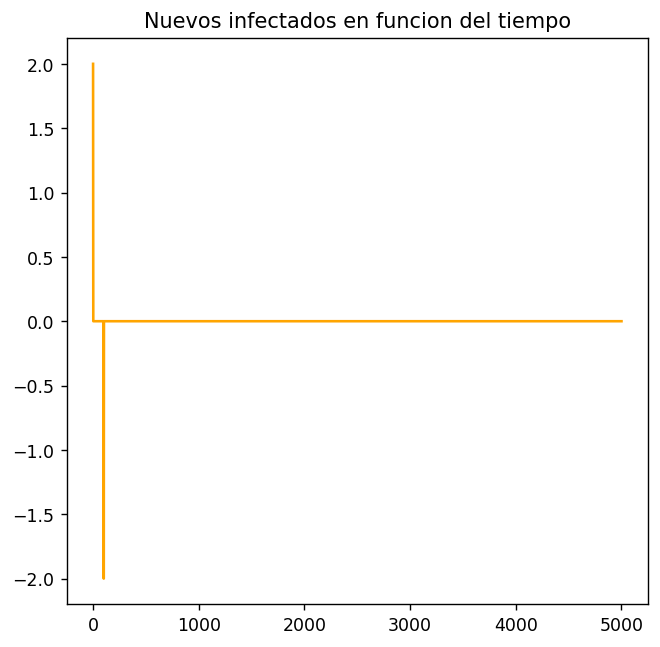

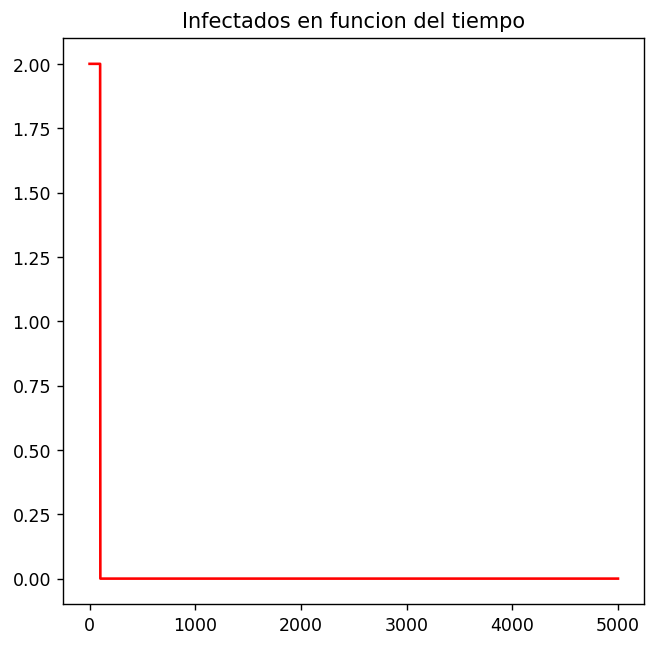

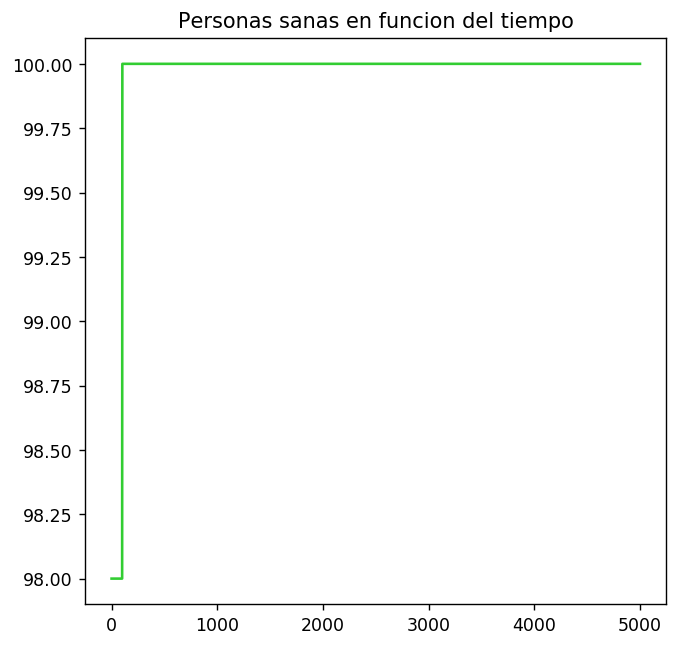

In [401]:
graficar_analisis_situacional_con_cuarentena(0)

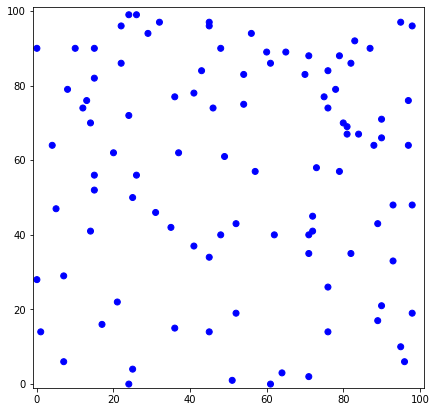

In [387]:
anim = animar_analisis_situacional_con_cuarentena(0)
HTML(anim.to_html5_video())

## Situacion 2
Se puede mover el 50% de la población

1
2


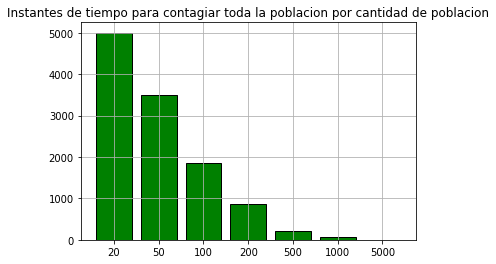

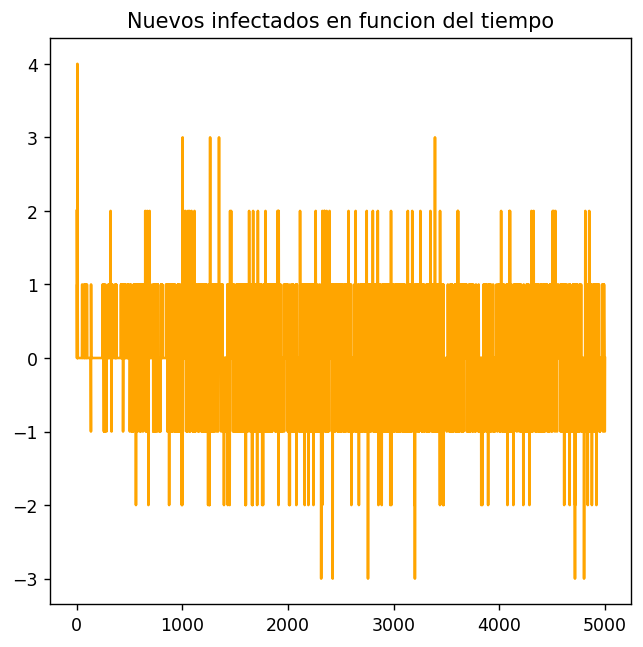

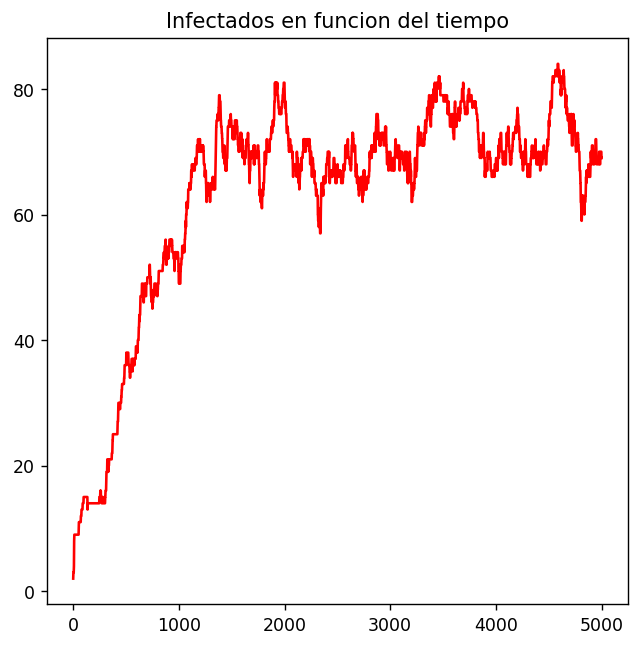

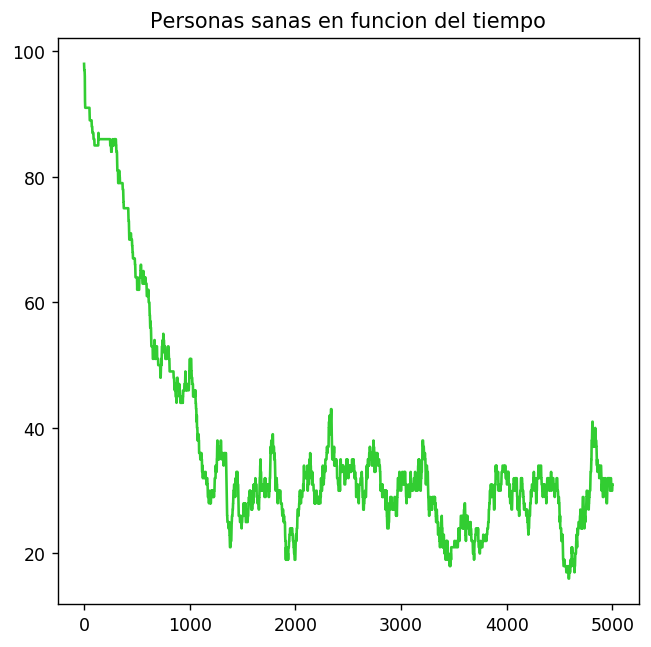

In [402]:
graficar_analisis_situacional_con_cuarentena(0.5)

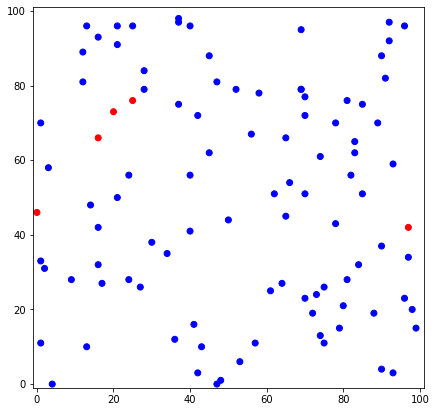

In [403]:
anim = animar_analisis_situacional_con_cuarentena(0.5)
HTML(anim.to_html5_video())

## Situacion 3
Se puede mover el 75% de la población

1
2


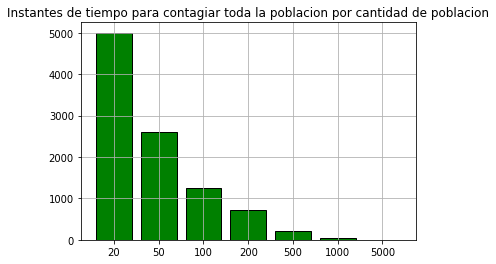

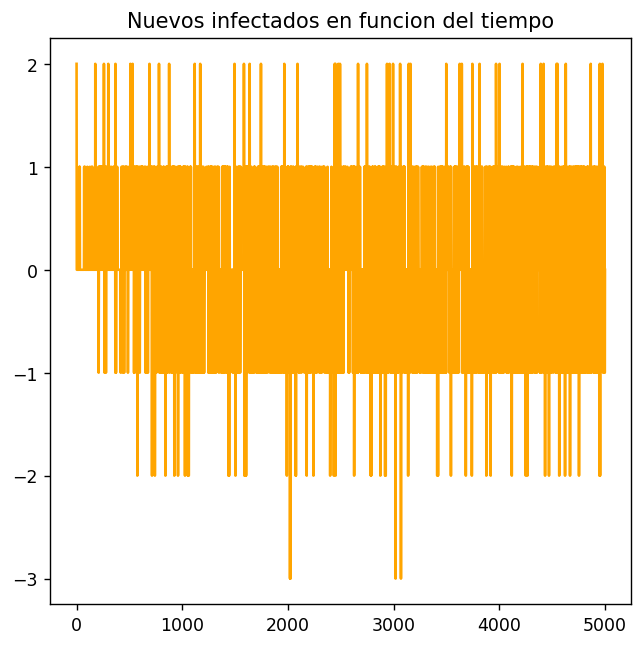

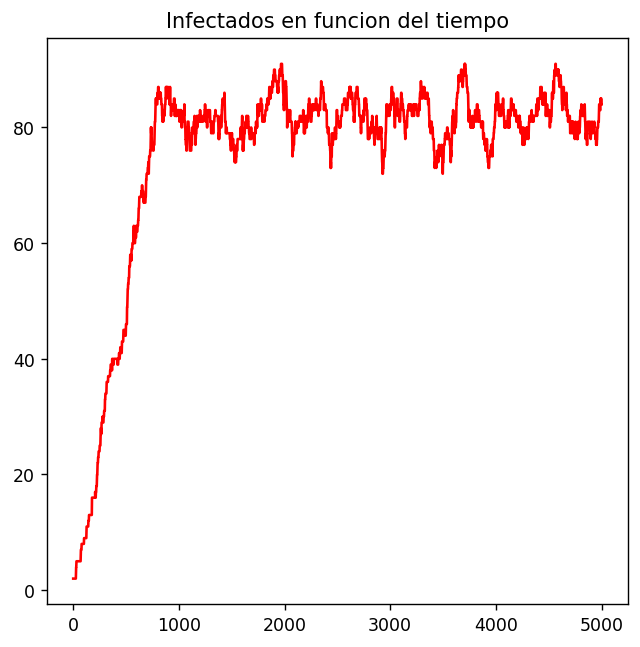

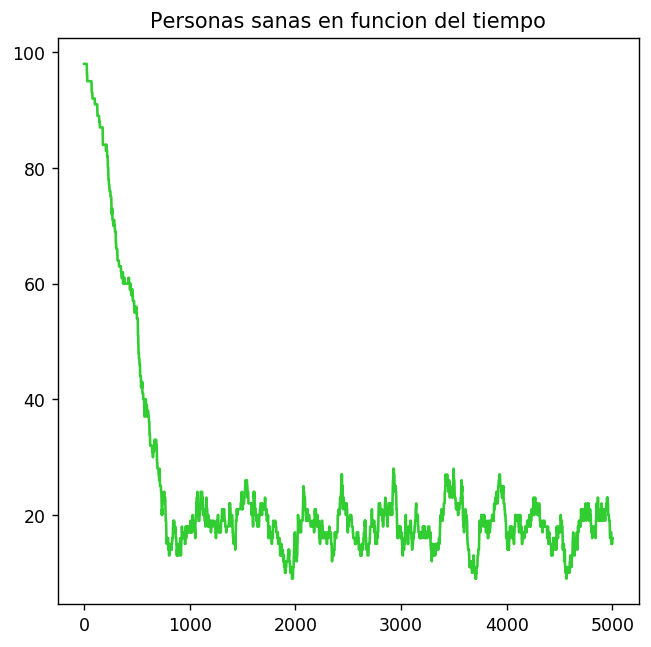

In [404]:
graficar_analisis_situacional_con_cuarentena(0.75)

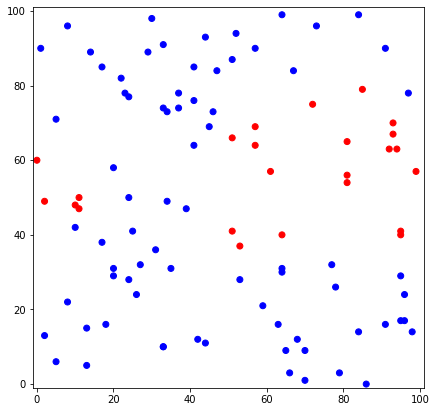

In [406]:
anim = animar_analisis_situacional_con_cuarentena(0.75)
HTML(anim.to_html5_video())